##Experiment6: [Main File 3]Cityscapes transfer learning synthia UNET

##Installing dependencies and data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
if devices:
    for device in devices:
        print(device.name)
else:
    print('No GPU devices found')

/physical_device:GPU:0


In [3]:
import tensorflow as tf

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# Create a TensorFlow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

In [5]:
train_folder="/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/train"
valid_folder="/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

In [6]:
print("Number of images in the training dataset:", num_of_training_samples)
print("Number of images in the testing/validation dataset:", num_of_testing_samples)


Number of images in the training dataset: 2975
Number of images in the testing/validation dataset: 500


In [ ]:
train_folder = "/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/train"
valid_folder = "/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/val"

# Get the width and height of images in the train folder
train_files = os.listdir(train_folder)
train_image_path = os.path.join(train_folder, train_files[0])
train_image = Image.open(train_image_path)
train_width, train_height = train_image.size

# Get the width and height of images in the valid folder
valid_files = os.listdir(valid_folder)
valid_image_path = os.path.join(valid_folder, valid_files[0])
valid_image = Image.open(valid_image_path)
valid_width, valid_height = valid_image.size

print("Width and height of images in the training folder:")
print("Width:", train_width)
print("Height:", train_height)

print("Width and height of images in the validation folder:")
print("Width:", valid_width)
print("Height:", valid_height)


Width and height of images in the training folder:
Width: 512
Height: 256
Width and height of images in the validation folder:
Width: 512
Height: 256


##Preprocessing the training and testing dataset

1.] Load image and segmentation mask

In [7]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

2.] One hot encoding

In [8]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

In [9]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

In [10]:
def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

3.] Genearator function

In [11]:
def DataGenerator(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

##Visualizing data samples

In [12]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [13]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

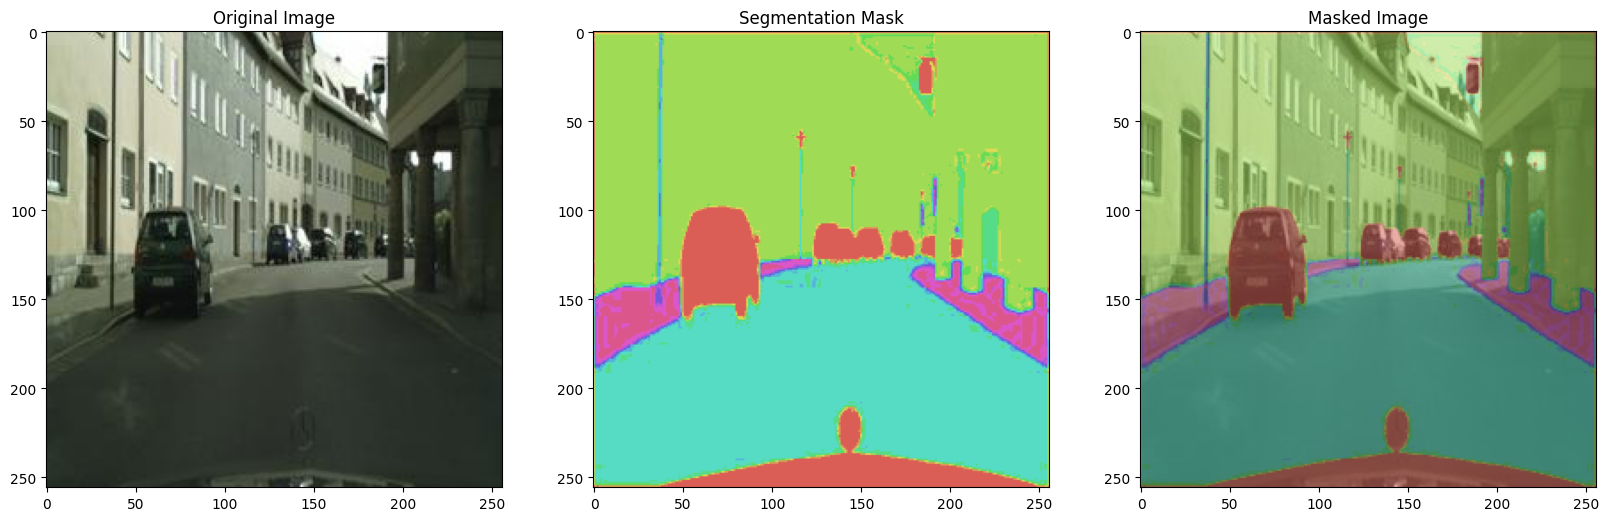

In [14]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

##Defining model

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the U-Net model
def build_unet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Contracting path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Expanding path
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = keras.Model(inputs, outputs)
    return model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import pydot

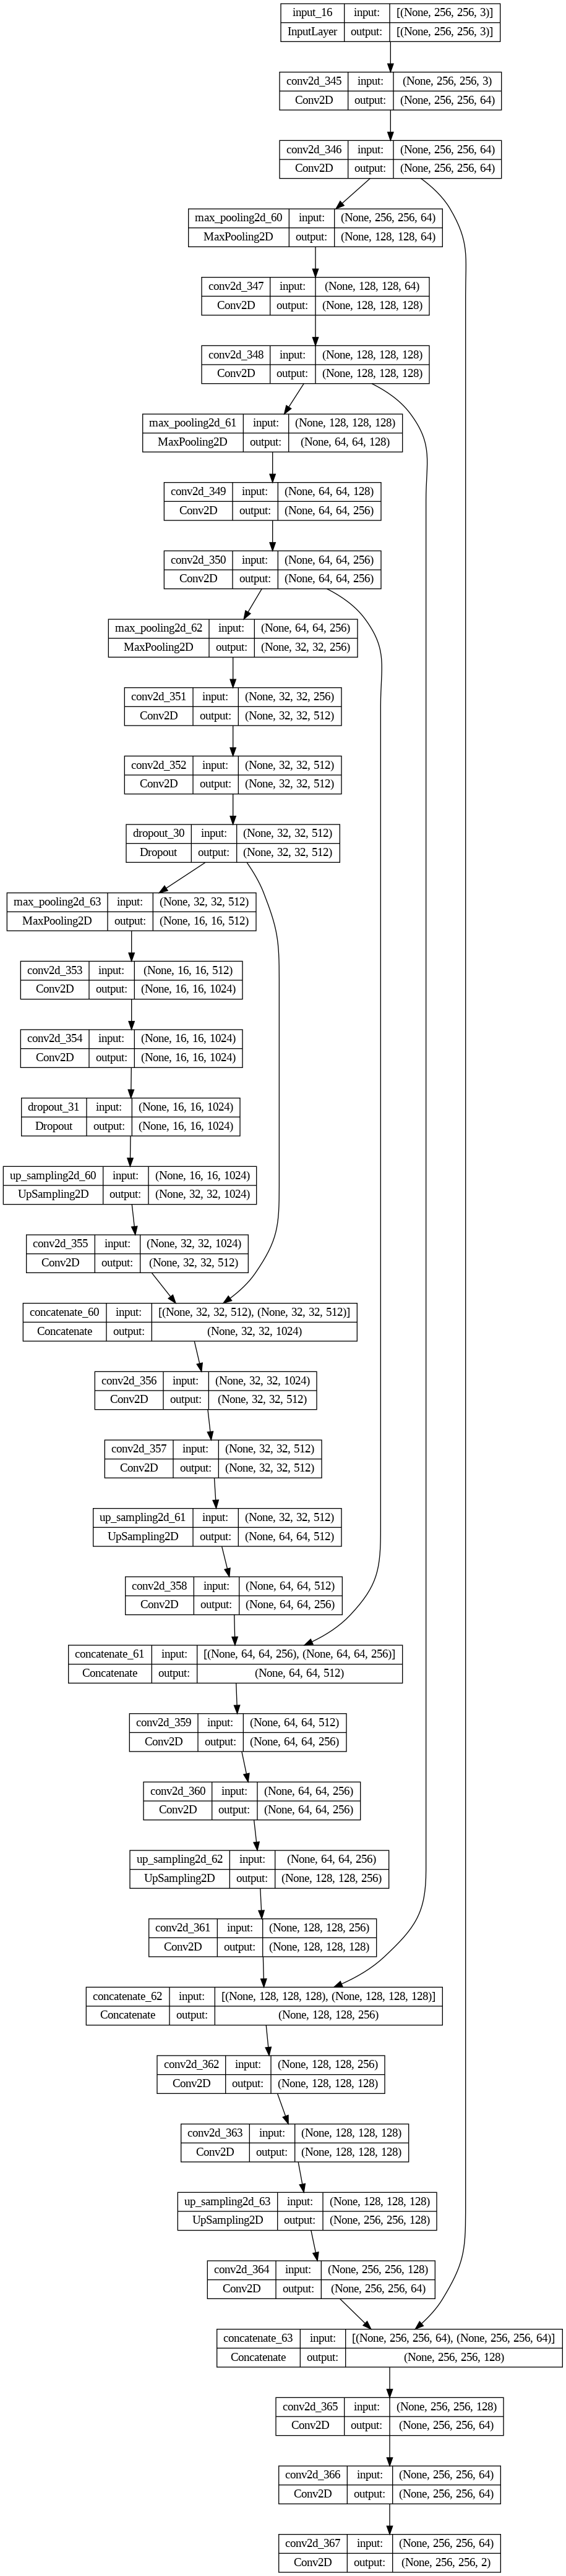

In [39]:
# Build the U-Net model
input_shape = (256, 256, 3)
num_classes = 2
unet_model = build_unet_model(input_shape, num_classes)

# Visualize the model
plot_model(unet_model, to_file='unet_model.png', show_shapes=True)

In [40]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
import pydot

# Build the U-Net model
input_shape = (256, 256, 3)
num_classes = 2
unet_model = build_unet_model(input_shape, num_classes)

# Convert the model to a dot object
dot_model = model_to_dot(unet_model, show_shapes=True, show_layer_names=True)

# Save the dot object as an image
dot_model.write_png('unet_model.png')

True

In [31]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


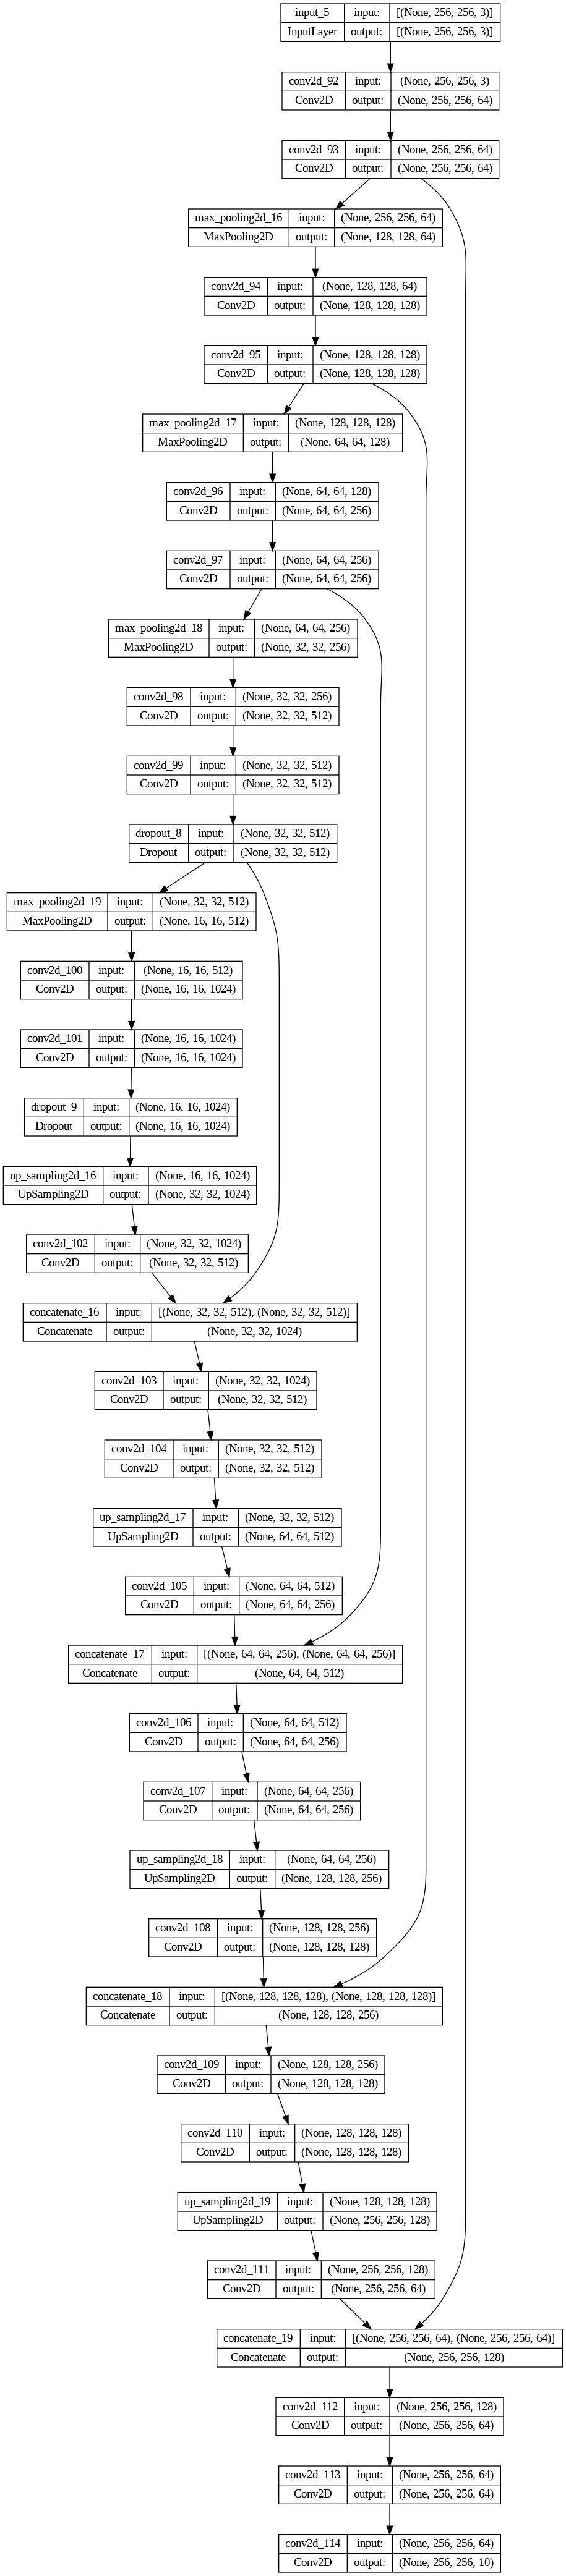

In [30]:
# Create an instance of the U-Net model
input_shape = (256, 256, 3)  # Example input shape
num_classes = 10  # Example number of classes
model = build_unet_model(input_shape, num_classes)

# Visualize the model in U-shape
plot_model(model, to_file='unet_model.png', show_shapes=True, expand_nested=True, dpi=96)

In [ ]:
from tensorflow.keras.utils import plot_model
model = build_unet_model(input_shape=(256, 256, 3), num_classes=13)

# Display the model summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

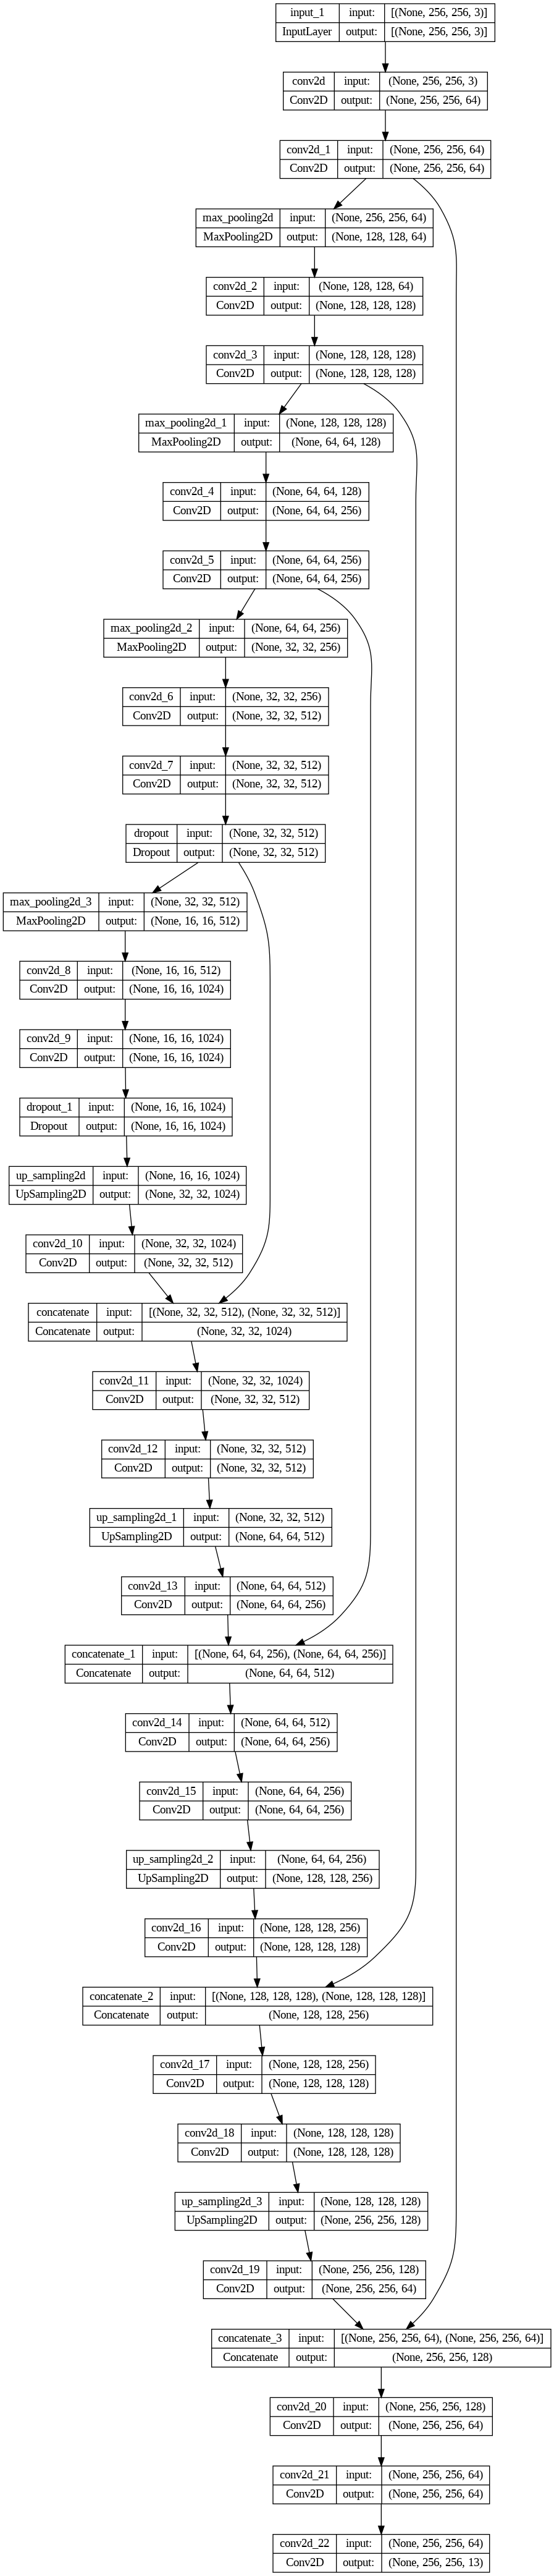

In [ ]:

# Save the model architecture diagram to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Display the model architecture diagram in Jupyter Notebook
from PIL import Image
image = Image.open('model_architecture.png')
image.show()


## Transfer learning from weights of synthia dataset

In [ ]:
pretrained_model = keras.models.load_model('/content/drive/MyDrive/ParametersDeepLearning/notebook5/best-model-fcn.hdf5')


In [ ]:
input_shape = (height, width, 3)
num_classes = 13
model = build_unet_model(input_shape, num_classes)

In [ ]:
for pretrained_layer, new_model_layer in zip(pretrained_model.layers, model.layers):
    new_model_layer.set_weights(pretrained_layer.get_weights())


## Training model

In [ ]:
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "best-model-vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=num_of_training_samples // batch_size,
                    validation_data=val_gen, validation_steps=num_of_testing_samples // batch_size,
                    callbacks=callbacks_list, use_multiprocessing=True)

<ipython-input-24-e34adbc86321>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,


Epoch 1/10
297/297 [==============================] - ETA: 0s - loss: 1.1192 - accuracy: 0.6788
Epoch 1: val_accuracy improved from -inf to 0.70389, saving model to best-model-vgg.hdf5
297/297 [==============================] - 300s 924ms/step - loss: 1.1192 - accuracy: 0.6788 - val_loss: 1.0672 - val_accuracy: 0.7039
Epoch 2/10
297/297 [==============================] - ETA: 0s - loss: 0.9265 - accuracy: 0.7361
Epoch 2: val_accuracy improved from 0.70389 to 0.74496, saving model to best-model-vgg.hdf5
297/297 [==============================] - 250s 843ms/step - loss: 0.9265 - accuracy: 0.7361 - val_loss: 0.8984 - val_accuracy: 0.7450
Epoch 3/10
297/297 [==============================] - ETA: 0s - loss: 0.8444 - accuracy: 0.7600
Epoch 3: val_accuracy improved from 0.74496 to 0.76275, saving model to best-model-vgg.hdf5
297/297 [==============================] - 248s 835ms/step - loss: 0.8444 - accuracy: 0.7600 - val_loss: 0.8430 - val_accuracy: 0.7628
Epoch 4/10
297/297 [==============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


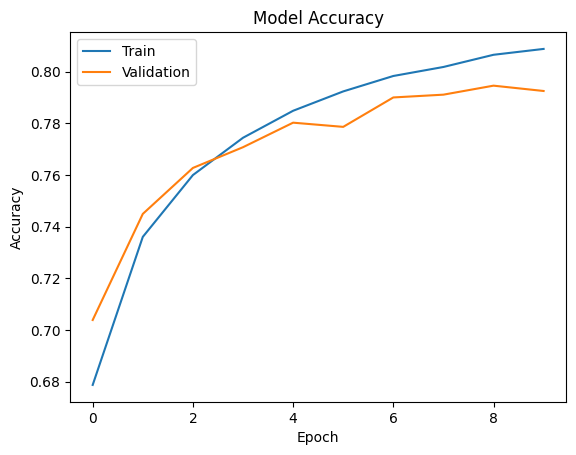

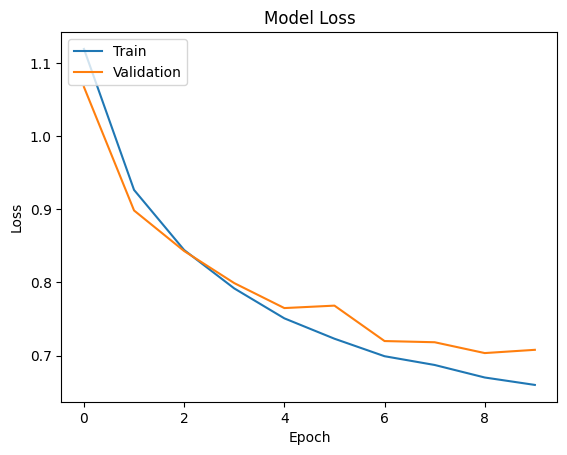

<ipython-input-30-8f1d017b9691>:29: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_accuracy = model.evaluate_generator(val_gen, steps=num_of_testing_samples // batch_size)


Validation Loss: 0.7034920454025269
Validation Accuracy: 0.7946054935455322


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the saved history
with open('/content/history.pkl', 'rb') as file:
    history = pickle.load(file)

# Print available metrics
print(history.keys())

# Plot accuracy and loss curves
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate_generator(val_gen, steps=num_of_testing_samples // batch_size)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


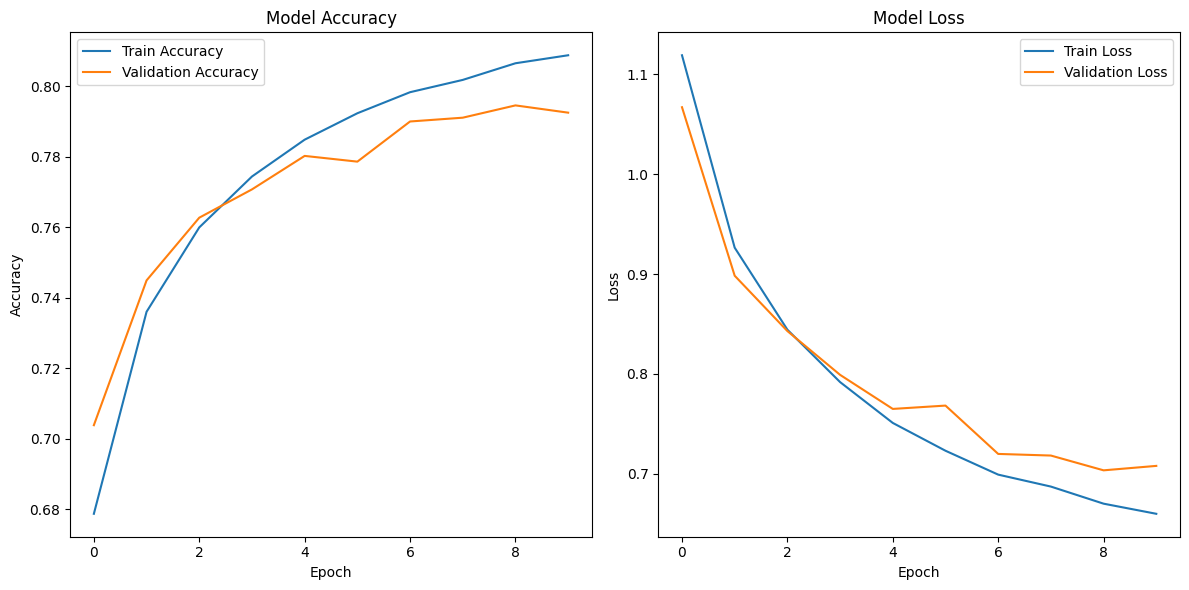

<ipython-input-34-bb2076463e22>:33: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_accuracy = model.evaluate_generator(val_gen, steps=num_of_testing_samples // batch_size)


Validation Loss: 0.7034920454025269
Validation Accuracy: 0.7946053743362427


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the saved history
with open('/content/history.pkl', 'rb') as file:
    history = pickle.load(file)

# Print available metrics
print(history.keys())

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate_generator(val_gen, steps=num_of_testing_samples // batch_size)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)



In [ ]:
import pickle

# Save the history dictionary to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history, file)

# Load the history dictionary from the file
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

# Access the training and validation metrics
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']



In [ ]:
# After training the model
model.save_weights("model_weights.h5")

##Visualization

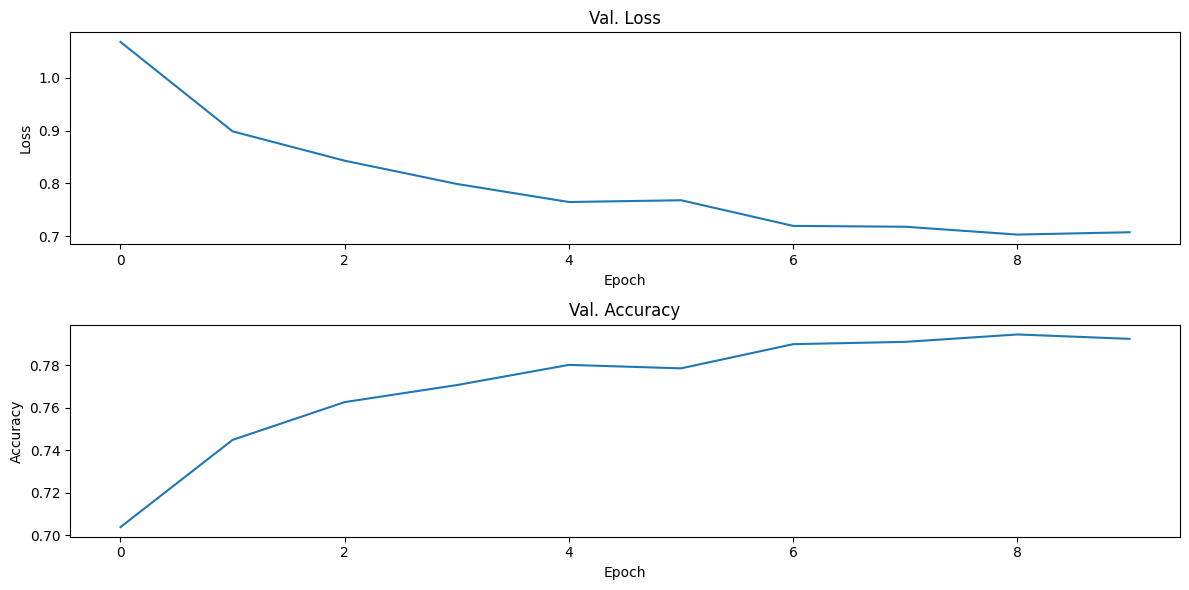

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(val_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()


In [ ]:
model.load_weights("best-model-vgg.hdf5")

1/1 [==============================] - 0s 257ms/step


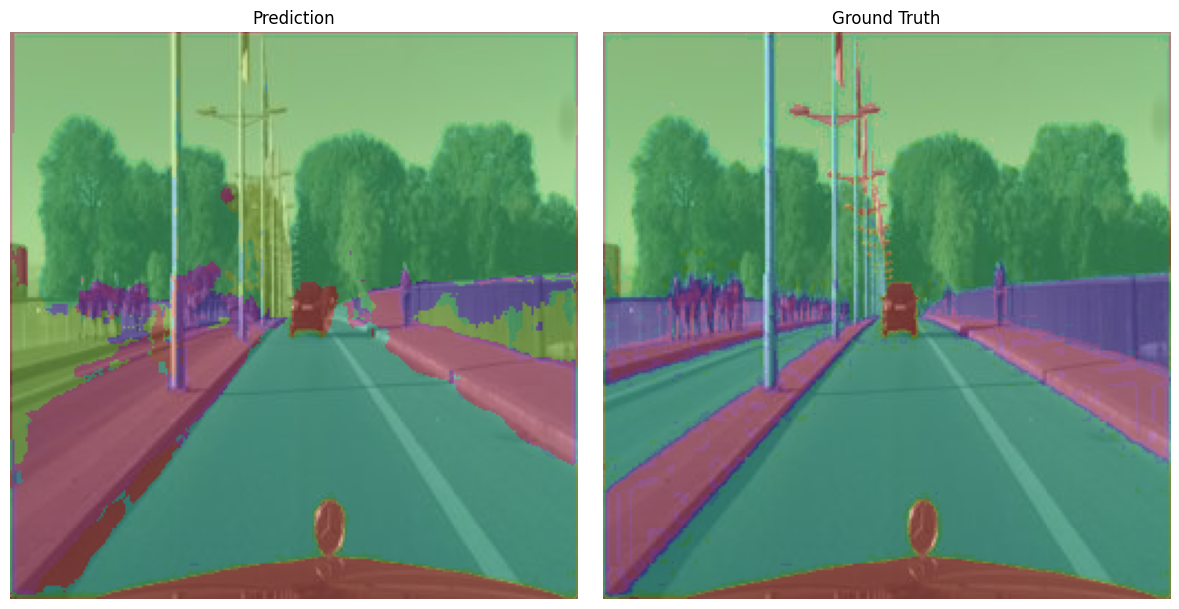

In [ ]:
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(122)
    plt.title("Ground Truth")
    plt.imshow(trueimg)
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("pred_{}.png".format(i), dpi=150)
    plt.show()


In [ ]:
import shutil

source_path = "/content/pred_0.png"
destination_path = "/content/drive/MyDrive/ParametersDeepLearning/notebook6/pred_0.png"

shutil.copyfile(source_path, destination_path)


'/content/drive/MyDrive/ParametersDeepLearning/notebook6/pred_0.png'